<a href="https://colab.research.google.com/github/Ifeeding99/tensorflow-scripts/blob/main/car_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving car detection.zip to car detection.zip


In [ ]:
import zipfile
f = zipfile.ZipFile('car detection.zip')
f.extractall('object_detection')

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.data import Dataset
import cv2
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalMaxPool2D, Dropout, Dense, Multiply, GlobalAveragePooling2D

In [ ]:
img_size = 256
images_path = 'object_detection/data/training_images'
bounding_boxes_path = 'object_detection/data/train_solution_bounding_boxes (1).csv'

df_bounding_boxes = pd.read_csv(bounding_boxes_path)

dictionary = {}
for i,img in enumerate(df_bounding_boxes.image):
    dictionary[images_path+'/'+img] = [float(df_bounding_boxes.xmin[i]), float(df_bounding_boxes.ymin[i]),float(df_bounding_boxes.xmax[i]), float(df_bounding_boxes.ymax[i])]

img_list = []
X, Y1, Y2 = [],[], []

for img in os.listdir(images_path):
    img_list.append(os.path.join(images_path,img))


In [ ]:
def get_bounding_box(path):
    if path in list(dictionary.keys()):
        return path, [[1],dictionary[path]]
    return path, [[0],[0,0,0,0]]

def process_image(path):
    image, label = get_bounding_box(path)
    image = cv2.imread(path)
    #image = cv2.resize(image,(img_size,img_size))
    X.append(image)
    Y1.append(label[0])
    Y2.append(label[1])

for img in img_list:
    process_image(img)

In [ ]:
X = np.array(X)
Y1 = np.array(Y1)
Y2 = np.array(Y2)
X_train = X[:int(1000*0.8)]
X_val = X[int(1000*0.8):]
y_train_1 = Y1[:int(1000*0.8)]
y_train_2 = Y2[:int(1000*0.8)]
y_val_1 = Y1[int(1000*0.8):]
y_val_2 = Y2[int(1000*0.8):]

pretrained_layer = VGG19(include_top = False)
pretrained_layer.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# model
input_ = Input(shape = (None,None,3), name = 'input')
x = preprocess_input(input_)
x = pretrained_layer(x)
pooled = GlobalAveragePooling2D()(x)

x_class = Dense(1024, activation = tf.nn.relu)(pooled)
d_1 = Dropout(0.5)(x_class)
x_class_output = Dense(1, activation = 'sigmoid', name = 'class')(d_1)

x_reg_1 = tf.keras.layers.BatchNormalization()(pooled)
x_reg_2 = Dense(1024, activation = tf.nn.relu)(x_reg_1)
x_reg_3 = tf.keras.layers.BatchNormalization()(x_reg_2)
x_reg_4 = Dense(1024, activation = tf.nn.relu)(x_reg_3)
d_2 = Dropout(0.5)(x_reg_4)
x_reg_output = Dense(4, name = 'box')(d_2)
#x_reg_output = x_reg * img_size

model = Model(inputs = input_, outputs = [x_class_output, x_reg_output])


model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = {'class': 'binary_crossentropy',
                        'box': tfa.losses.GIoULoss()}, # tf.math.multiply, tfa.losses.GIoULoss
              metrics={'class': 'binary_accuracy',
                        'box': 'mean_absolute_error'})

training = model.fit(X_train,(y_train_1,y_train_2),
                     validation_data = [X_val, (y_val_1, y_val_2)],
                     epochs = 100,
                     batch_size = 64)

Epoch 1/100
13/13 [==============================] - 34s 2s/step - loss: 2.2962 - class_loss: 0.9066 - box_loss: 1.3896 - class_binary_accuracy: 0.6687 - box_mean_absolute_error: 103.2476 - val_loss: 1.7371 - val_class_loss: 0.2530 - val_box_loss: 1.4841 - val_class_binary_accuracy: 0.8856 - val_box_mean_absolute_error: 102.5064
Epoch 2/100
13/13 [==============================] - 31s 2s/step - loss: 1.6038 - class_loss: 0.2704 - box_loss: 1.3334 - class_binary_accuracy: 0.8938 - box_mean_absolute_error: 106.0588 - val_loss: 1.6291 - val_class_loss: 0.2121 - val_box_loss: 1.4170 - val_class_binary_accuracy: 0.9104 - val_box_mean_absolute_error: 102.4844
Epoch 3/100
13/13 [==============================] - 31s 2s/step - loss: 1.5145 - class_loss: 0.1814 - box_loss: 1.3331 - class_binary_accuracy: 0.9275 - box_mean_absolute_error: 107.1165 - val_loss: 1.5492 - val_class_loss: 0.1826 - val_box_loss: 1.3666 - val_class_binary_accuracy: 0.9353 - val_box_mean_absolute_error: 102.9897
Epoch 4

KeyboardInterrupt: ignored

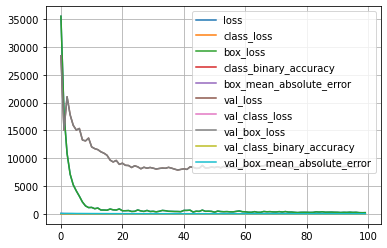

In [ ]:
history = pd.DataFrame(training.history)
history.plot()
plt.grid()

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
model.save('car_detection_model_v2_1.hdf5')

1/1 [==============================] - 0s 38ms/step
[[0.9999269]]
[355, 95, 391, 113]
438 184 495 212


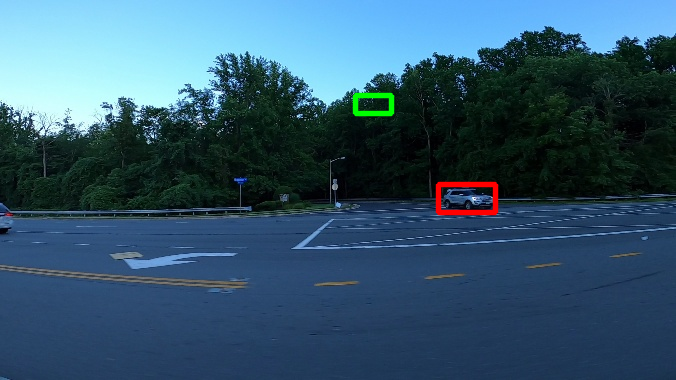

In [ ]:
image_path = 'object_detection/data/training_images/vid_4_960.jpg'
file = cv2.imread(image_path)
file_to_model = cv2.resize(file, (img_size,img_size))
img_to_model = np.array(file_to_model).reshape((-1,img_size,img_size,3))
class_predicted, coordinates = model.predict(img_to_model)
print(class_predicted)
if round(class_predicted[0][0]) > 0.5:
    points = [round(n) for n in coordinates[0]]
    print(points)
    print(round(dictionary[image_path][0]),round(dictionary[image_path][1]),round(dictionary[image_path][2]),round(dictionary[image_path][3]))
    x_min = points[0]
    y_min = points[1]
    x_max = points[2]
    y_max = points[3]
    a = (x_min,y_max)
    b = (x_max,y_min)
    x_min_real = round(dictionary[image_path][0])
    y_min_real = round(dictionary[image_path][1])
    x_max_real = round(dictionary[image_path][2])
    y_max_real = round(dictionary[image_path][3])
    a_real = (x_min_real,y_max_real)
    b_real = (x_max_real,y_min_real)
    cv2.rectangle(file, pt1 = a, pt2 = b, color=(0, 255, 0), thickness=3, lineType=cv2.LINE_AA)
    cv2.rectangle(file, pt1 = a_real, pt2 = b_real, color = (0,0,255), thickness=3, lineType=cv2.LINE_AA)
cv2_imshow(file)